# mount drive

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive',force_remount=False)

shared_folder = '/content/drive/Shared drives/CS476'
os.chdir(shared_folder)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls

ArbFrVec.ipynb		 instrintic_evaluation.ipynb
google_ar2fr_single.pkl  natural-potion-459221-v6-3032c41951d7.json
google_fr2ar_single.pkl  randomshuffle_5window_skipgram_300size.model


# packages

In [ ]:
!pip uninstall -y gensim numpy scipy scikit-learn

!pip install "numpy==1.24.4" "scipy==1.10.1" "scikit-learn==1.3.2" "gensim==4.3.3"


Found existing installation: gensim 4.3.3
Uninstalling gensim-4.3.3:
  Successfully uninstalled gensim-4.3.3
Found existing installation: numpy 1.24.4
Uninstalling numpy-1.24.4:
  Successfully uninstalled numpy-1.24.4
Found existing installation: scipy 1.10.1
Uninstalling scipy-1.10.1:
  Successfully uninstalled scipy-1.10.1
Found existing installation: scikit-learn 1.3.2
Uninstalling scikit-learn-1.3.2:
  Successfully uninstalled scikit-learn-1.3.2
  Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached scipy-1.10.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (58 kB)
  Using cached scikit_learn-1.3.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
Using cached scipy-1.10.1-c

In [ ]:
# Test the installation
import numpy, gensim, sklearn
print("NumPy :", numpy.__version__)
print("Gensim:", gensim.__version__)
print("sklearn:", sklearn.__version__)


NumPy : 1.24.4
Gensim: 4.3.3
sklearn: 1.3.2


In [ ]:
!pip install matplotlib arabic-reshaper python-bidi regex


In [ ]:
import numpy as np
import gensim
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display
import regex
import random
import time
import pickle
from random import sample

# load models

In [ ]:
model_path = "randomshuffle_5window_skipgram_300size.model"
cred_path  = "natural-potion-459221-v6-3032c41951d7.json"
ar2fr_pkl  = "google_ar2fr_single.pkl"
fr2ar_pkl  = "google_fr2ar_single.pkl"


In [ ]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = cred_path


In [ ]:
ar_full = []
fr_full=[]

with open(ar2fr_pkl, "rb") as f:
    ar2fr = pickle.load(f)

with open(fr2ar_pkl, "rb") as f:
    fr2ar = pickle.load(f)


In [ ]:
modelLocation = 'randomshuffle_5window_skipgram_300size.model'
model = Word2Vec.load(modelLocation)
vocabulary_list = model.wv.index_to_key


# Seed 42 so it gives the same answer each time we run it
random.seed(42)
N_TEST = 1000

sample_all = sample(vocabulary_list,N_TEST)


In [ ]:
def is_Arabic(word):
    re_arabic = regex.compile(r'\p{arabic}')
    return bool(re_arabic.search(word))


# t-SNE

In [ ]:
keys_ar =[]
keys_fr=[]
for src in sample_all:

    neighbour,_ = model.wv.most_similar(src, topn=1)[0]


    gold = ar2fr[src] if is_Arabic(src) else fr2ar[src]



    if  (neighbour.lower() == gold[0].lower()):
        if(is_Arabic(src)):
            keys_ar.append(src)
        else:
            keys_fr.append(src)


keys=[]
for i in range(9):
    keys.append(keys_ar[i])
    keys.append(keys_fr[i])

In [ ]:
embedding_clusters = []
word_clusters = []
for word in keys:
  embeddings = []
  embeddings.append(model.wv[word])

  words = []
  words.append(word)

  for similar_word, _ in model.wv.most_similar(word, topn = 2):
    words.append(similar_word)
    embeddings.append(model.wv[similar_word])

  embedding_clusters.append(embeddings)
  word_clusters.append(words)

embedding_clusters = np.array(embedding_clusters)
word_clusters = np.ravel(np.array(word_clusters))
n, m, k = embedding_clusters.shape

In [ ]:
tsne_model_fr_2d = TSNE(perplexity=15, n_components=2, init='random', n_iter=3500, random_state=0)
embeddings_fr_2d = np.array(tsne_model_fr_2d.fit_transform(embedding_clusters.reshape(n * m, k)))


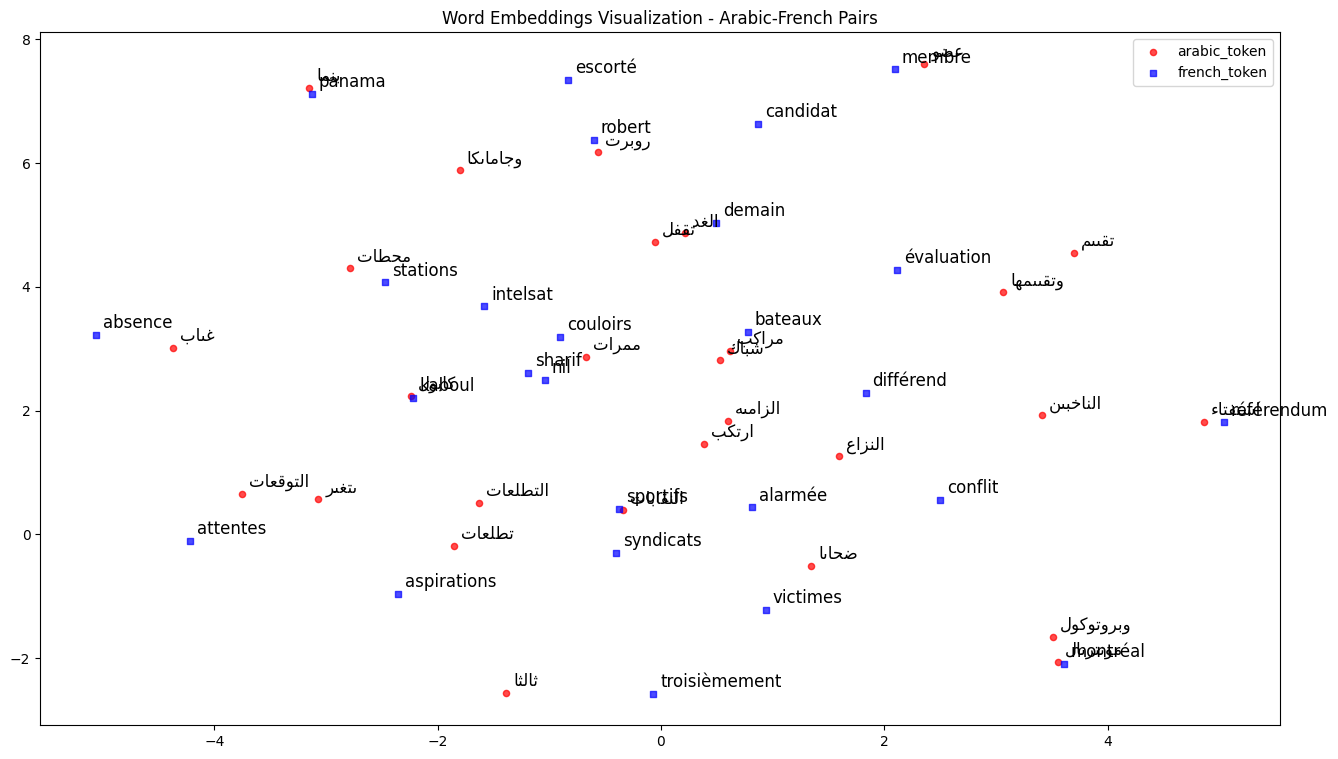

In [ ]:
plt.figure(figsize=(16,9))

AR = []
FR = []

for i, word in enumerate(word_clusters):

    if is_Arabic(word):
      AR.append((word, embeddings_fr_2d[i][0], embeddings_fr_2d[i][1]))
    else:
      FR.append((word, embeddings_fr_2d[i][0], embeddings_fr_2d[i][1]))

plt.scatter([ar[1] for ar in AR], [ar[2] for ar in AR], c='red', alpha = 0.7, s=20, marker='o', label = 'arabic_token')
plt.scatter([fr[1] for fr in FR], [fr[2] for fr in FR], c ='blue', alpha=0.7, s=20, marker='s', label = 'french_token')

for i, word in enumerate(word_clusters):
    if is_Arabic(word):
      display_word = arabic_reshaper.reshape(word)
      display_word = get_display(display_word)
    else :
      display_word = word
    plt.annotate(display_word, alpha=1, xy=(embeddings_fr_2d[i][0], embeddings_fr_2d[i][1])
    , xytext=(5,2), textcoords='offset points', ha='left', va='bottom',size=12)


plt.legend(loc='best')
plt.title('Word Embeddings Visualization - Arabic-French Pairs')
plt.show()

